In [31]:
%pip install keras_tuner


Note: you may need to restart the kernel to use updated packages.


# Disaster Tweet RNN Kaggle Project

For this project, we are assessing tweets related to "disasters" to see if the tweets are about disasters or are not about real disasters.
This is an example of a binary classification problem. We can think of non-disaster tweets as having a label of "0" and real disasters as a label of "1".

We have been given a set of training data that consists of 10,000 tweets that have been "hand classified". The data is all text, in a sparse matrix format. There are id, keyword, location and text columns. In the test data set there is a "target" column that represents the label. Not all of these columns have been filled out for each tweet. In fact many tweets are missing the keyword and location values.

The train dataset follows the same formay, but the matrix is missing the target column. there are jsut under 3700 tweets in the test dataset. 

In [37]:
import pandas as pd
import numpy as np
import keras_tuner as kt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


In [15]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [43]:
print(train_data.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [44]:
print(test_data.head())

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


## EDA

Lets start by comparing the most common locations and keywords from the disaster tweets to that of the non-disaster tweets.

/var/folders/9d/vpbdr4351299v3vk9mfh83_00000gn/T/ipykernel_22294/1474706655.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Keyword', data=disaster_keyword_df, palette='Reds')
/var/folders/9d/vpbdr4351299v3vk9mfh83_00000gn/T/ipykernel_22294/1474706655.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Keyword', data=non_disaster_keyword_df, palette='Blues')


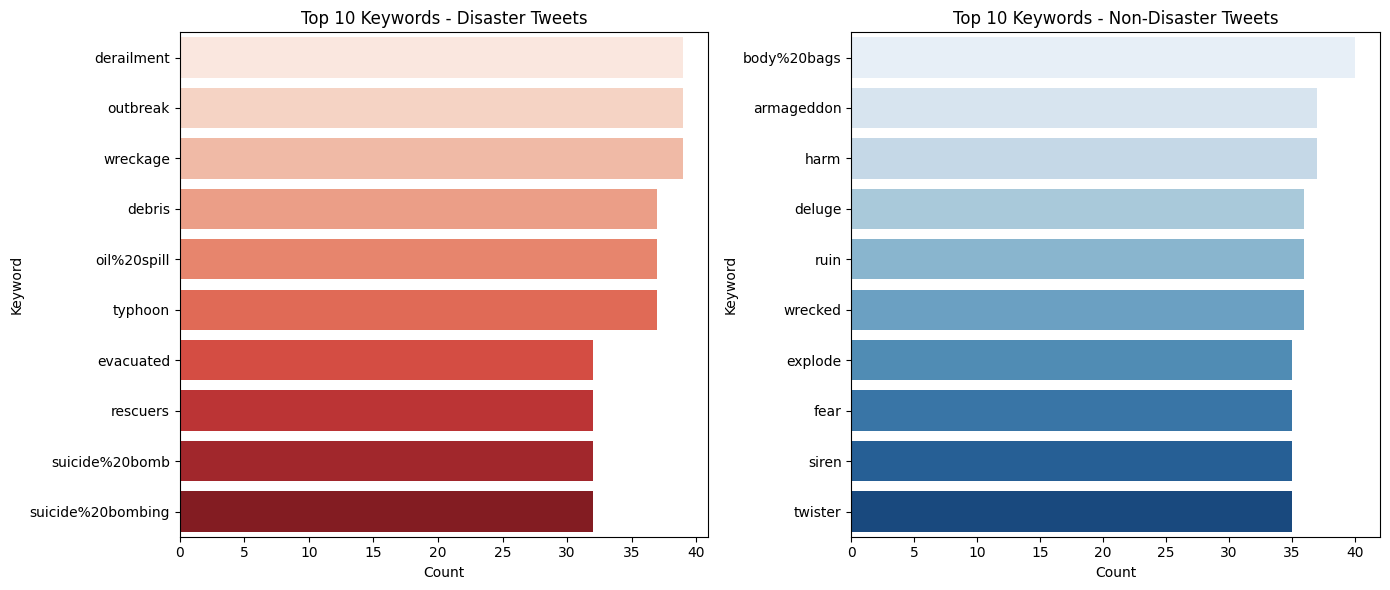

/var/folders/9d/vpbdr4351299v3vk9mfh83_00000gn/T/ipykernel_22294/1474706655.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Location', data=disaster_location_df, palette='Reds')
/var/folders/9d/vpbdr4351299v3vk9mfh83_00000gn/T/ipykernel_22294/1474706655.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Location', data=non_disaster_location_df, palette='Blues')


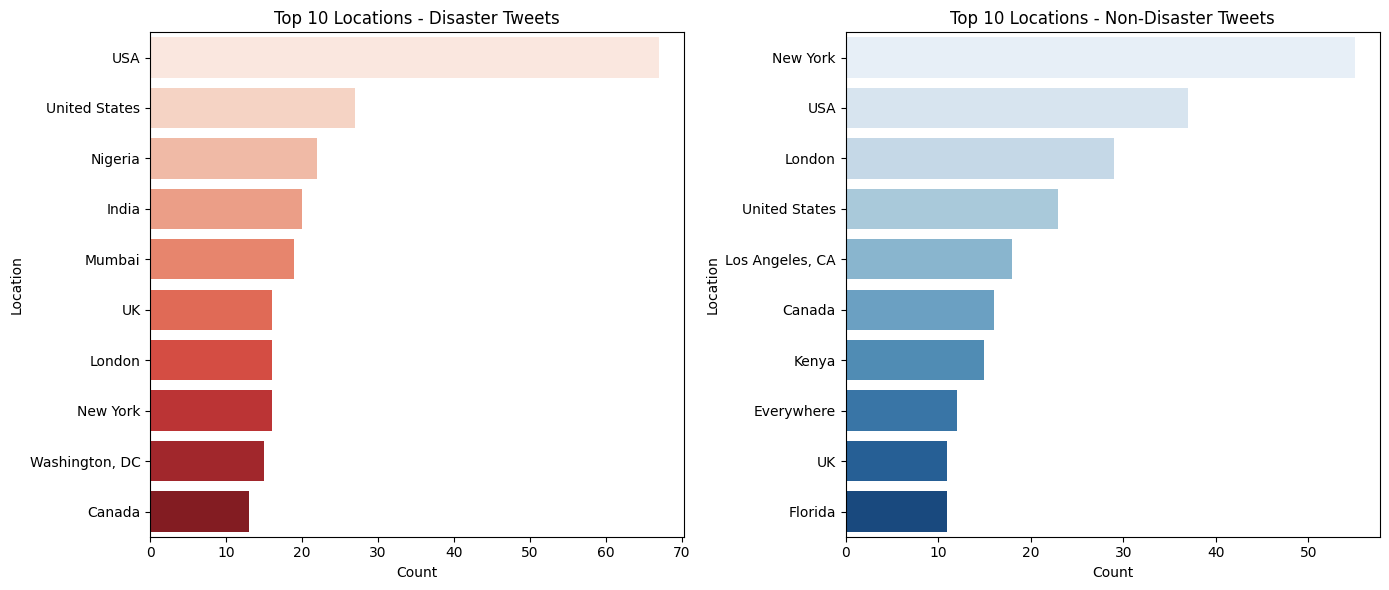

In [28]:
# Top 10 Keywords for each target (disaster vs non-disaster)
disaster_keywords = train_data[train_data['target'] == 1]['keyword'].dropna()
non_disaster_keywords = train_data[train_data['target'] == 0]['keyword'].dropna()

# Get the top 10 most common keywords for each label
disaster_keyword_counts = Counter(disaster_keywords)
non_disaster_keyword_counts = Counter(non_disaster_keywords)

top_10_disaster_keywords = disaster_keyword_counts.most_common(10)
top_10_non_disaster_keywords = non_disaster_keyword_counts.most_common(10)

# Prepare data for plotting
disaster_keyword_df = pd.DataFrame(top_10_disaster_keywords, columns=['Keyword', 'Count'])
non_disaster_keyword_df = pd.DataFrame(top_10_non_disaster_keywords, columns=['Keyword', 'Count'])

# Plot for Keywords
plt.figure(figsize=(14, 6))

# Plot for Disaster Keywords
plt.subplot(1, 2, 1)
sns.barplot(x='Count', y='Keyword', data=disaster_keyword_df, palette='Reds')
plt.title('Top 10 Keywords - Disaster Tweets')

# Plot for Non-Disaster Keywords
plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Keyword', data=non_disaster_keyword_df, palette='Blues')
plt.title('Top 10 Keywords - Non-Disaster Tweets')

plt.tight_layout()
plt.show()


# Top 10 Locations for each target (disaster vs non-disaster)
disaster_locations = train_data[train_data['target'] == 1]['location'].dropna()
non_disaster_locations = train_data[train_data['target'] == 0]['location'].dropna()

# Get the top 10 most common locations for each label
disaster_location_counts = Counter(disaster_locations)
non_disaster_location_counts = Counter(non_disaster_locations)

top_10_disaster_locations = disaster_location_counts.most_common(10)
top_10_non_disaster_locations = non_disaster_location_counts.most_common(10)

# Prepare data for plotting
disaster_location_df = pd.DataFrame(top_10_disaster_locations, columns=['Location', 'Count'])
non_disaster_location_df = pd.DataFrame(top_10_non_disaster_locations, columns=['Location', 'Count'])

# Plot for Locations
plt.figure(figsize=(14, 6))

# Plot for Disaster Locations
plt.subplot(1, 2, 1)
sns.barplot(x='Count', y='Location', data=disaster_location_df, palette='Reds')
plt.title('Top 10 Locations - Disaster Tweets')

# Plot for Non-Disaster Locations
plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Location', data=non_disaster_location_df, palette='Blues')
plt.title('Top 10 Locations - Non-Disaster Tweets')

plt.tight_layout()
plt.show()

Lets compare the total volume of disaster vs non disaster tweets. 

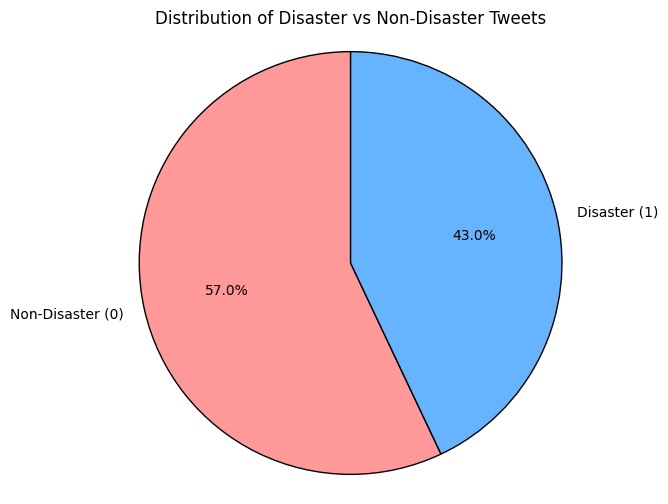

In [24]:
import matplotlib.pyplot as plt

# Assuming your dataset is stored in `train_data`
target_counts = train_data['target'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=['Non-Disaster (0)', 'Disaster (1)'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Disaster vs Non-Disaster Tweets')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

This next graph is a little more interesting. First we are assesing which words are most unique to both disaster and non-disaster tweets.
Then we are sorting these.

The graph has the 10 most strongly associated each with both label groups, and then also the 10 most centerly associated.

/var/folders/9d/vpbdr4351299v3vk9mfh83_00000gn/T/ipykernel_22294/3959521410.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=selected_keywords.index, x=selected_keywords['disaster_diff'], palette='coolwarm')


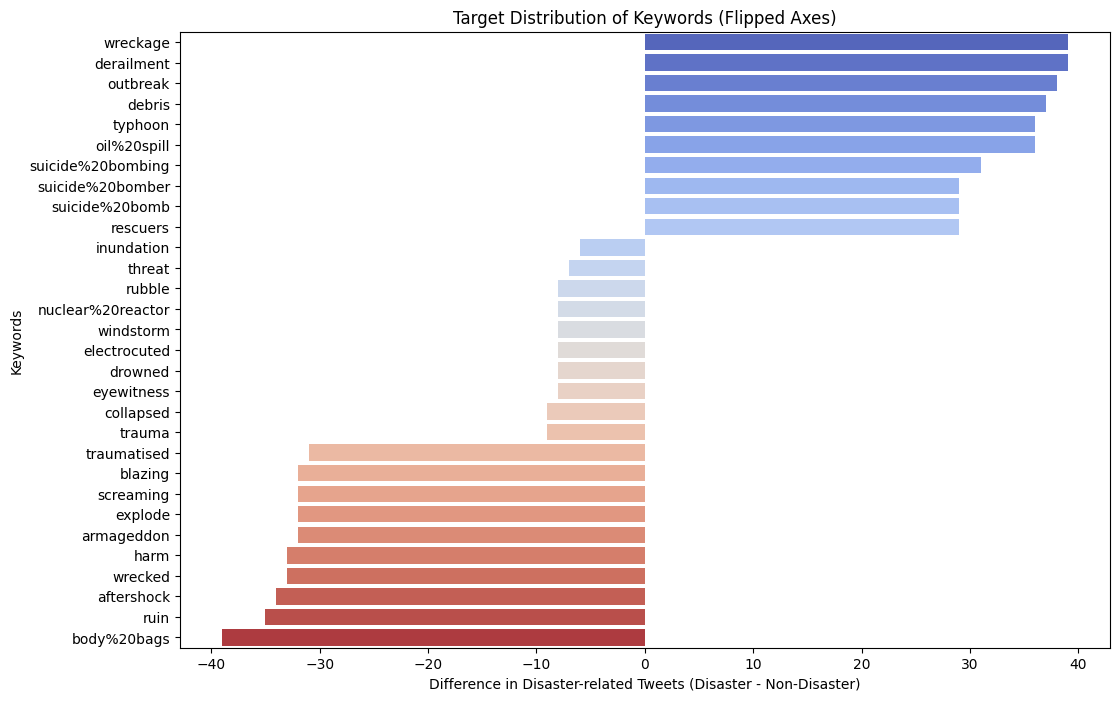

In [27]:
# Assuming your dataset is stored in `train_data`

# Step 1: Get the count of disaster (target = 1) and non-disaster (target = 0) tweets for each keyword
keyword_target_counts = train_data.groupby(['keyword', 'target']).size().unstack(fill_value=0)

# Step 2: Calculate the difference between disaster and non-disaster tweets for each keyword
keyword_target_counts['disaster_diff'] = keyword_target_counts[1] - keyword_target_counts[0]

# Step 3: Sort the keywords by the difference in disaster-related tweets
sorted_keywords = keyword_target_counts.sort_values(by='disaster_diff', ascending=False)

# Step 4: Select top 10 keywords with highest disaster-related tweets, bottom 10 with least disaster-related, and 10 from the middle
top_10_disaster = sorted_keywords.head(10)
bottom_10_disaster = sorted_keywords.tail(10)

# For middle 10, we can pick keywords around the median of disaster_diff values
middle_10_disaster = sorted_keywords.iloc[len(sorted_keywords)//2-5:len(sorted_keywords)//2+5]

# Combine the three subsets
selected_keywords = pd.concat([top_10_disaster, middle_10_disaster, bottom_10_disaster])

# Step 5: Plot with flipped axes
plt.figure(figsize=(12, 8))
sns.barplot(y=selected_keywords.index, x=selected_keywords['disaster_diff'], palette='coolwarm')

plt.title('Target Distribution of Keywords (Flipped Axes)')
plt.xlabel('Difference in Disaster-related Tweets (Disaster - Non-Disaster)')
plt.ylabel('Keywords')
plt.show()

This is a simple function to clean urls, "mentions" and punctuation from the text in the data matrix.

In [ ]:
# Preprocess the tweets (remove URLs, mentions, etc.)
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\S+', '', text)    # Remove mentions
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)  # Remove non-alphanumeric characters
    return text.lower()

# Apply the cleaning function to both train and test data
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

We are not tokenizing the text. I am using the simple Tokenizer method from keras.
This method has two steps. 

1) fit_on_texts updates internal vocabulary based on a list of texts. This method also considers the frequency of words. Each word gets a unique integer value, and lower integers refer to more frequently used words.
2) texts_to_sequences transforms each text in all of the text into a sequence of integers. 

In [ ]:
# Tokenize the tweets
tokenizer = Tokenizer(num_words=10000)  # Limit the vocabulary to the top 10,000 words
tokenizer.fit_on_texts(train_data['cleaned_text'])

# Convert texts to sequences of tokens
X_train = tokenizer.texts_to_sequences(train_data['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test_data['cleaned_text'])

Here we are padding the data. This ensures that all inputs (tweets) are of the same length. 

We also make sure that the test data matrix has a target or label column to add the preduictions to.

In [ ]:
# Pad the sequences to ensure they are of equal length
max_len = 100  # You can adjust this based on the average tweet length
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

# Prepare the target labels (only from train.csv)
y_train = train_data['target'].values

In [49]:
def make_charts(history):

    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Basic Model Architecture

1) First we initialize a sequential model. This is a linear stack of layers.

2) We then add an embedding layer, this converts the integer tokens into dense vectors of a fixed size.
-   input_dim specifies the size of the vocabulary -- how many unique words will be considered.
-   output dim is the dimension of the dense embeddding vectors. So in this case each word is represented as a 128 dimensional vector.
-   input_length defines the length of the input sequences. All tweets shoudl have a length that is this number long. If shorter it will be padded, if longer it will be truncated.

3) adding a simple RNN layer
-   128 is the number of units in the RNN layer.
-   This rnn is set up so that it will only return the final output from the last timestamp

4) Droput layer
-   This is to try and prevent overfitting.
-   this is set to drop 20% of the neurons in the layer at random

5) dense output layer
-   this adds a fully connected layer with 1 neuron.
-   this activation function is the sigmoid function



In [48]:

basic_model = Sequential()
basic_model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
basic_model.add(SimpleRNN(128, return_sequences=False))
basic_model.add(Dropout(0.2))
basic_model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification


# Compile the basic_model
basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history0 = basic_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5


/Users/andrewkeohane/Documents/mscs/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5482 - loss: 0.6919 - val_accuracy: 0.4924 - val_loss: 0.7311
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5289 - loss: 0.7204 - val_accuracy: 0.5483 - val_loss: 0.7280
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6114 - loss: 0.6665 - val_accuracy: 0.5259 - val_loss: 0.7038
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5870 - loss: 0.6820 - val_accuracy: 0.5194 - val_loss: 0.7217
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5958 - loss: 0.6726 - val_accuracy: 0.5345 - val_loss: 0.7058


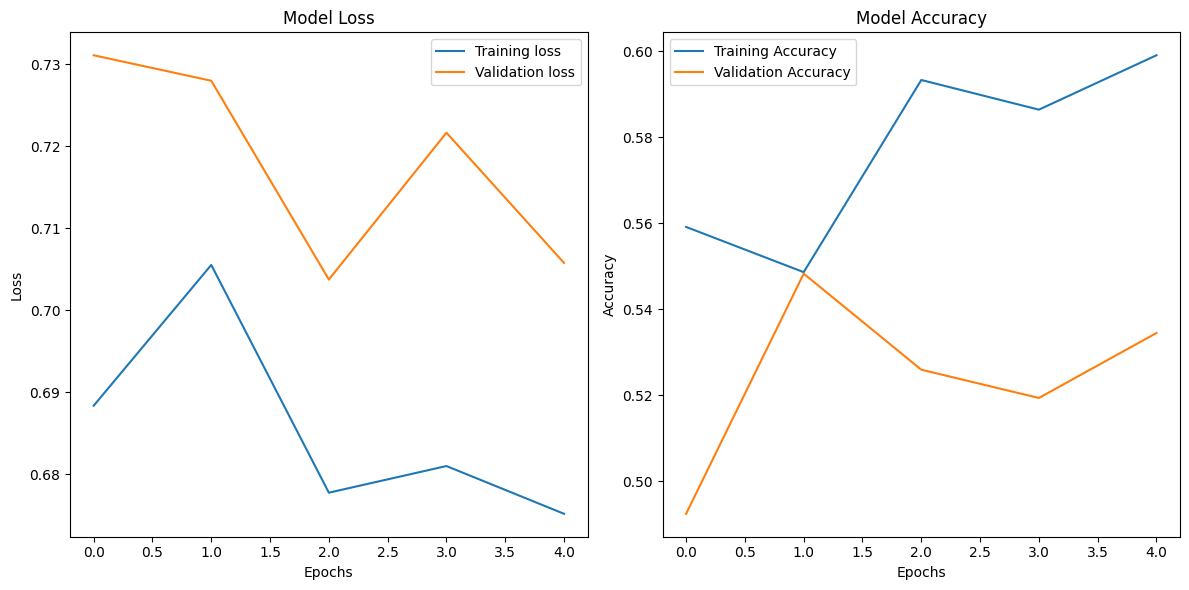

In [50]:
make_charts(history0)

## Complex model architecture

1) First we initialize a sequential model. This is a linear stack of layers.

2) Embedding layer
-  larger vocabular on this model
-   dimensionality has been reduced on the output vector of this layer
-   tweets have been shortened

3) add a bidriectional layer
-   This is a LSTM layer this is a RNN that tries to capture long term dependancies in sequential data.
-   This layer makes the LSTM layer process the input in both directions.

4) Dense layers
-  we are adding two dense layers to this model. 
-   the first is a relu layer, this hidden layer alows the model to capture and learn complex patterns
-   the second dense layer is a sigmoid function, this will serve as the output layer for binary classification. 

In [45]:
model = Sequential([
    Embedding(16070, 32, input_length=20),
    Bidirectional(LSTM(64)),
    Dense(14, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model and track the history
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Predict on the test data (we don't have target for test, so we just predict the labels)
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Prepare the submission file (we only have 'id' in test.csv, so we use it)
submission = pd.DataFrame({
    'id': test_data['id'],
    'target': y_pred.flatten()
})

Epoch 1/10


/Users/andrewkeohane/Documents/mscs/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.5992 - loss: 0.6625 - val_accuracy: 0.7334 - val_loss: 0.5307
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8450 - loss: 0.3877 - val_accuracy: 0.7879 - val_loss: 0.4587
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9043 - loss: 0.2582 - val_accuracy: 0.7892 - val_loss: 0.4804
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9331 - loss: 0.1862 - val_accuracy: 0.7774 - val_loss: 0.5618
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9552 - loss: 0.1326 - val_accuracy: 0.7564 - val_loss: 0.6813
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9632 - loss: 0.1046 - val_accuracy: 0.7564 - val_loss: 0.6743
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9667 - loss: 0.0980 - val_accuracy: 0.7538 - val_loss: 0.7525
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9707 - loss: 0.0876 - val_accuracy: 0.7466 - val_loss: 0

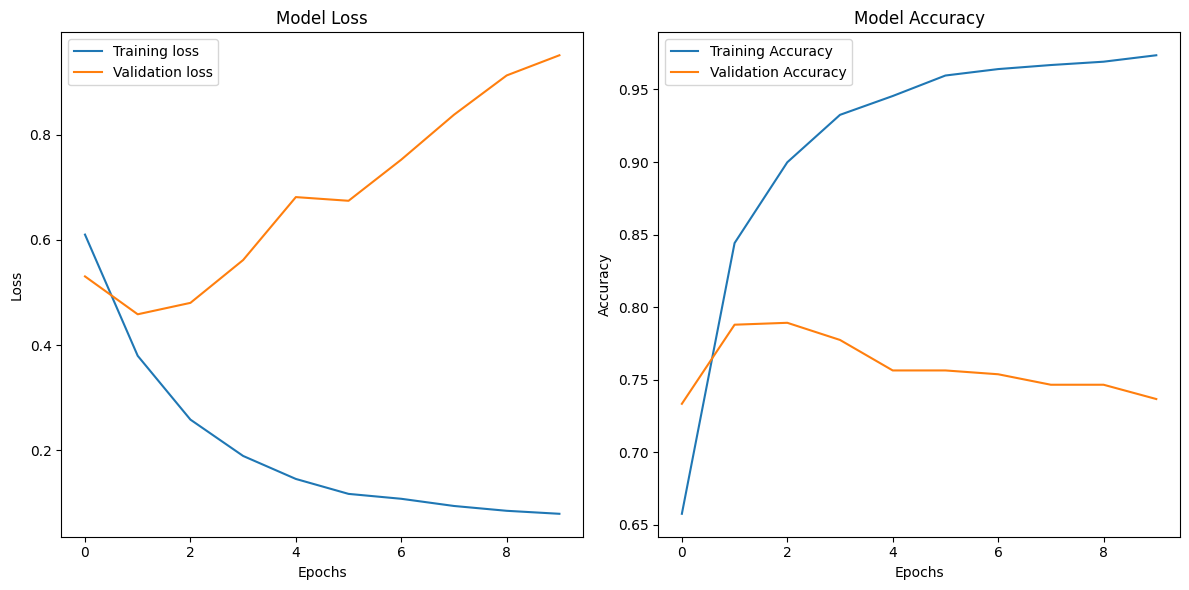

In [47]:
make_charts(history)

# Analysis of Two Models:
The second, slightly more complex model is able to make more accurtate predictions than the simple model is.
However, despite the higher accuracy, the progression on validation accuracy and validation loss over the epochs suggests overfitting.
We should see if we can improve this though use of hyperparameters, including a dropout layer.

There are likely several reasons for this:
1) Bidirection LSTM layer
-   This gives the model information about the both the past and the future context of the input data.

2) LSTM vs Simple RNN
-   LSTM networks are going to perform better on sequential tasks than simple RNNs are because they are able to capture context from disparate parts of the tweet. -- It can consider the context of the first word on the last and vice versa. Language is rather finiky -- adding or removing one word here or there can totally change the meaning of a statement. As can the order of words. For example "I love to make bread" is very diffent than "I make love to bread".

3) adding the dense layer with Relu activation
-   In the second model we have added an additional layer with Relu activation function.
-   This allows the network to capture more complex patterns by considering non-linear relationships.


In [33]:
def build_model(hp):
    model = Sequential([
        # Embedding Layer
        Embedding(input_dim=16070, 
                  output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=32), 
                  input_length=20),
        
        # Bidirectional LSTM Layer
        Bidirectional(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), 
                            dropout=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1),
                            recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.2, max_value=0.5, step=0.1))),
        
        # Dense Layer
        Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'),
        Dropout(rate=hp.Float('dense_dropout', min_value=0.2, max_value=0.5, step=0.1)),
        
        # Output Layer
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        loss='binary_crossentropy', 
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')), 
        metrics=['accuracy']
    )
    
    return model

## Hyperparameter tuning

We will be using the karas tuner package to optimize our hyperparameters

there are 6 parameters we are going to optimize:

### 1: Embedding layer
-   we will adjust the number of units and input length

### 2: LSTM Layer
-   we are going to adjust the number of units, and add Dropout or Recurring dropout
-   to goal is to see if we can reduce overfitting

### 3: Dense layer
-   experiment with a different number of neurons, and with different activation functions

### 4: Optimizer
-   Try different options like SGD, RMSprop or Adam with different learning rates

### 5: Batch size
-   reduce or increase the batch size

### 6: Epochs
-   Consider both more epochs and early stopping


In [34]:
# Set up the tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',  # We aim to maximize validation accuracy
    max_trials=5,  # Number of different combinations to try
    executions_per_trial=1,  # Number of training runs per combination
    directory='tuner_results',  # Directory to store results
    project_name='disaster_tweet_model'  # Project name for the search
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Run hyperparameter search
tuner.search(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Trial 5 Complete [00h 03m 24s]
val_accuracy: 0.7925148010253906

Best val_accuracy So Far: 0.7938279509544373
Total elapsed time: 00h 12m 51s


In [35]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters: ", best_hyperparameters.values)

# Build the best model using the found hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)


Best Hyperparameters:  {'embedding_dim': 32, 'lstm_units': 128, 'dropout': 0.30000000000000004, 'recurrent_dropout': 0.30000000000000004, 'dense_units': 96, 'dense_dropout': 0.4, 'learning_rate': 0.00020945278125419103}


In [ ]:
history1 = best_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 282ms/step - accuracy: 0.5720 - loss: 0.6852 - val_accuracy: 0.5345 - val_loss: 0.6861
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - accuracy: 0.6004 - loss: 0.6585 - val_accuracy: 0.7577 - val_loss: 0.5608
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 300ms/step - accuracy: 0.7876 - loss: 0.4866 - val_accuracy: 0.7840 - val_loss: 0.4915
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 294ms/step - accuracy: 0.8300 - loss: 0.4001 - val_accuracy: 0.7814 - val_loss: 0.4649
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 263ms/step - accuracy: 0.8601 - loss: 0.3392 - val_accuracy: 0.7919 - val_loss: 0.4635
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 282ms/step - accuracy: 0.8755 - loss: 0.2997 - val_accuracy: 0.7853 - val_loss: 0.4627
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 330ms/step - accuracy: 0.8996 - loss: 0.2622 - val_accuracy: 0.7708 - val_loss: 0.4868
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 296ms/step - accuracy: 0.9077 - loss: 0.2400 - val_accu

In [ ]:
make_charts(history1)

In [ ]:
# Predict on the test data (we don't have target for test, so we just predict the labels)
y_pred = (best_model.predict(X_test) > 0.5).astype(int)

# Prepare the submission file (we only have 'id' in test.csv, so we use it)
submission = pd.DataFrame({
    'id': test_data['id'],
    'target': y_pred.flatten()
})

# Save the results to a CSV file
submission.to_csv('submission.csv', index=False)

In [41]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=5)

# Print the best hyperparameters for each trial
for i, hp in enumerate(best_hyperparameters):
    print(f"Best hyperparameters for trial {i+1}: {hp.values}")

Best hyperparameters for trial 1: {'embedding_dim': 32, 'lstm_units': 128, 'dropout': 0.30000000000000004, 'recurrent_dropout': 0.30000000000000004, 'dense_units': 96, 'dense_dropout': 0.4, 'learning_rate': 0.00020945278125419103}
Best hyperparameters for trial 2: {'embedding_dim': 128, 'lstm_units': 128, 'dropout': 0.2, 'recurrent_dropout': 0.30000000000000004, 'dense_units': 96, 'dense_dropout': 0.30000000000000004, 'learning_rate': 0.0018095447285904397}
Best hyperparameters for trial 3: {'embedding_dim': 96, 'lstm_units': 96, 'dropout': 0.2, 'recurrent_dropout': 0.4, 'dense_units': 64, 'dense_dropout': 0.2, 'learning_rate': 0.00012659564752718217}
Best hyperparameters for trial 4: {'embedding_dim': 32, 'lstm_units': 64, 'dropout': 0.2, 'recurrent_dropout': 0.4, 'dense_units': 32, 'dense_dropout': 0.2, 'learning_rate': 0.0009563002231754367}
Best hyperparameters for trial 5: {'embedding_dim': 96, 'lstm_units': 128, 'dropout': 0.2, 'recurrent_dropout': 0.4, 'dense_units': 96, 'dense_

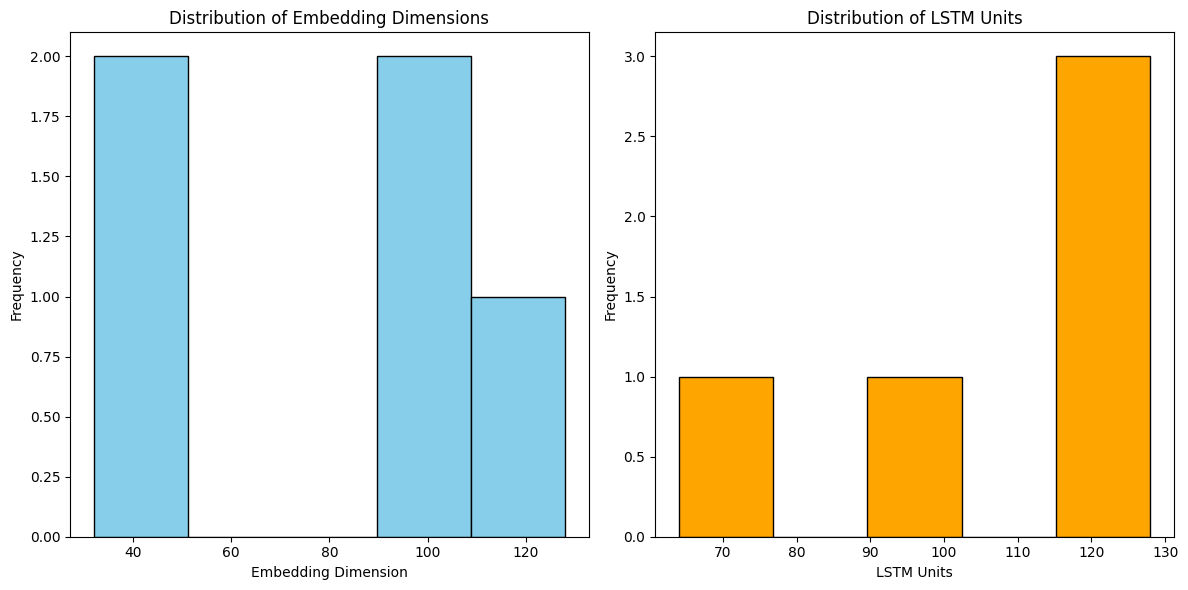

In [42]:
# Example of visualizing the distribution of best hyperparameters (e.g., 'embedding_dim' or 'lstm_units')
embedding_dims = [hp['embedding_dim'] for hp in best_hyperparameters]
lstm_units = [hp['lstm_units'] for hp in best_hyperparameters]

# Plot the distribution of hyperparameters
plt.figure(figsize=(12, 6))

# Plot distribution of embedding_dim
plt.subplot(1, 2, 1)
plt.hist(embedding_dims, bins=5, color='skyblue', edgecolor='black')
plt.xlabel('Embedding Dimension')
plt.ylabel('Frequency')
plt.title('Distribution of Embedding Dimensions')

# Plot distribution of lstm_units
plt.subplot(1, 2, 2)
plt.hist(lstm_units, bins=5, color='orange', edgecolor='black')
plt.xlabel('LSTM Units')
plt.ylabel('Frequency')
plt.title('Distribution of LSTM Units')

plt.tight_layout()
plt.show()

## Next steps -- ways to improve the network
1) Use of Pre-trained word embeddings

2) Increase model depth
-   perhaps as GRU layer

3) combine use with CNN.
-   this may improve feature extraction.

4) Improve pre-processing.
-   our preprocessing was extrememly limnited. We could certainly circle back and perhaps bring in TF-IDF or another method.

5) Use transformer based architecture
-   We have not covered these yet, but this may be a good next step for a model such as this.

6) Learn rate scheduling
-   we are using a constant learning rate in this model, we could consider a 

7) Tune the embedding layer